# 🎓 Vector Basics in OpenSearch: KNN Search Fundamentals

This notebook teaches you how to perform K-Nearest Neighbors (KNN) search using OpenSearch vectors with different engines and distance metrics.


## 📚 Vector Basics Learning Path

```mermaid
graph TD
    A["🎯 What is KNN Vector Search?<br/>Searching based on vector similarity"] --> B["📊 Part 1: Simple 2D Example<br/>Hotel Locations with L2 Distance"]
    
    B --> C["🏨 Create Index with<br/>2D Vector Field"]
    C --> D["📍 Index 5 Hotel Locations<br/>location: [x, y]"]
    D --> E["🔍 Search: Find Nearest Hotels<br/>to [5, 4]"]
    E --> F["📈 Visualize Results<br/>Show distances & ranking"]
    
    A --> G["🔧 Part 2: High-Dimensional Vectors<br/>Testing Different Configurations"]
    
    G --> H["⚙️ Generate 1024D<br/>Test Vectors"]
    H --> I["🎮 Test Multiple Engines<br/>faiss, lucene"]
    I --> J["📐 Test Multiple Distance Metrics<br/>l1, l2, linf, cosinesimil, innerproduct"]
    
    J --> K["🌟 Create Indices with<br/>Each Configuration"]
    K --> L["📊 Ingest & Index<br/>50 Test Vectors"]
    L --> M["⚡ Run KNN Searches<br/>Measure Speed & Accuracy"]
    
    M --> N["📉 Performance Comparison<br/>Search Latency & Quality"]
    N --> O["📊 2D Visualization<br/>PCA Projection of Results"]
    O --> P["🎓 Key Learnings<br/>Engine & Metric Selection"]
    
    F -.->|"Understand basics"| G
    P -.->|"Ready for production"| Q["🚀 Next Steps<br/>Production Deployment"]
    
    style A fill:#FF6B6B,color:#fff,stroke:#C92A2A,stroke-width:3px
    style B fill:#4ECDC4,color:#fff,stroke:#1A9B8E,stroke-width:2px
    style G fill:#45B7D1,color:#fff,stroke:#0C7792,stroke-width:2px
    style P fill:#96CEB4,color:#fff,stroke:#6BA587,stroke-width:2px
    style Q fill:#FFEAA7,color:#000,stroke:#FDCB6E,stroke-width:3px
    
    style C fill:#E8F5E9,color:#000
    style D fill:#E8F5E9,color:#000
    style E fill:#E3F2FD,color:#000
    style F fill:#FFF3E0,color:#000
    
    style H fill:#F3E5F5,color:#000
    style I fill:#FCE4EC,color:#000
    style J fill:#F0F4C3,color:#000
    style K fill:#E0F2F1,color:#000
    style L fill:#E8F5E9,color:#000
    style M fill:#FFEBEE,color:#000
    
    style N fill:#FFE0B2,color:#000
    style O fill:#C8E6C9,color:#000
```

### What You'll Learn:

| Section | Focus | Key Concepts |
|---------|-------|--------------|
| **Part 1** 🏨 | 2D Hotel Example | Basic KNN search, L2 distance, visualization |
| **Part 2** 🔧 | Configuration Testing | Engine selection, distance metrics, performance |
| **Analysis** 📊 | Comparative Study | Latency, accuracy, best practices |

---


In [1]:
from opensearchpy import OpenSearch
import sys, os
from opensearchpy.helpers import bulk

IS_AUTH = True
HOST = 'localhost'

# Get the current working directory of the notebook
current_dir = os.getcwd()

DATA_DIR = os.path.abspath(os.path.join(current_dir, '../../0. DATA'))

# Construct the path to the directory levels up
module_paths = [os.path.abspath(os.path.join(current_dir, '../../')),] 

# Add the module path to sys.path if it's not already there
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)

try:
    import helpers as hp
except ImportError as e:
    raise ImportError(f"Error importing modules: {e}")

if IS_AUTH:
    # Initialize the OpenSearch client
    client = OpenSearch(
        hosts=[{'host': HOST, 'port': 9200}],
        http_auth=('admin', 'Developer@123'),  # Replace with your credentials
        use_ssl=True,
        verify_certs=False,
        ssl_show_warn=False
    )
else:
    # Initialize the OpenSearch client without authentication
    client = OpenSearch(
        hosts=[{'host': HOST, 'port': 9200}],
        use_ssl=False,
        verify_certs=False,
        ssl_assert_hostname = False,
        ssl_show_warn=False
    )



# L2 distance

In [2]:
# Create vector index with mapping
# l2 means distance metrics is Euclidean distance
hotels_mapping = {
    "settings": {
        "index.knn": True
    },
    "mappings": {
        "properties": {
            "location": {
                "type": "knn_vector",
                "dimension": 2,
                "space_type": "l2"
            }
        }
    }
}

# Create the index
index_name = "hotels-index"
if client.indices.exists(index=index_name):
    client.indices.delete(index=index_name)

client.indices.create(index=index_name, body=hotels_mapping)
print(f"Created index: {index_name}")

# Add data to your index
hotels_data = [
    {"_index": "hotels-index", "_id": "1", "_source": {"location": [5.2, 4.4]}},
    {"_index": "hotels-index", "_id": "2", "_source": {"location": [5.2, 3.9]}},
    {"_index": "hotels-index", "_id": "3", "_source": {"location": [4.9, 3.4]}},
    {"_index": "hotels-index", "_id": "4", "_source": {"location": [4.2, 4.6]}},
    {"_index": "hotels-index", "_id": "5", "_source": {"location": [3.3, 4.5]}}
]

# Bulk insert the data
success, failed = bulk(client=client, actions=hotels_data)
print(f"Successfully indexed: {success} documents")

# Refresh the index to make documents available for search immediately
client.indices.refresh(index=index_name)
print("Index refreshed")

# Search your data using KNN
search_query = {
    "size": 3,
    "query": {
        "knn": {
            "location": {
                "vector": [5, 4],
                "k": 3
            }
        }
    }
}

# Execute the search
response = client.search(index="hotels-index", body=search_query)

print(f"Found {response['hits']['total']['value']} results:")
for hit in response['hits']['hits']:
    print(f"ID: {hit['_id']}, Score: {hit['_score']}, Location: {hit['_source']['location']}")

Created index: hotels-index
Successfully indexed: 5 documents
Index refreshed
Found 3 results:
ID: 2, Score: 0.952381, Location: [5.2, 3.9]
ID: 1, Score: 0.8333333, Location: [5.2, 4.4]
ID: 3, Score: 0.72992706, Location: [4.9, 3.4]


# Plot map

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


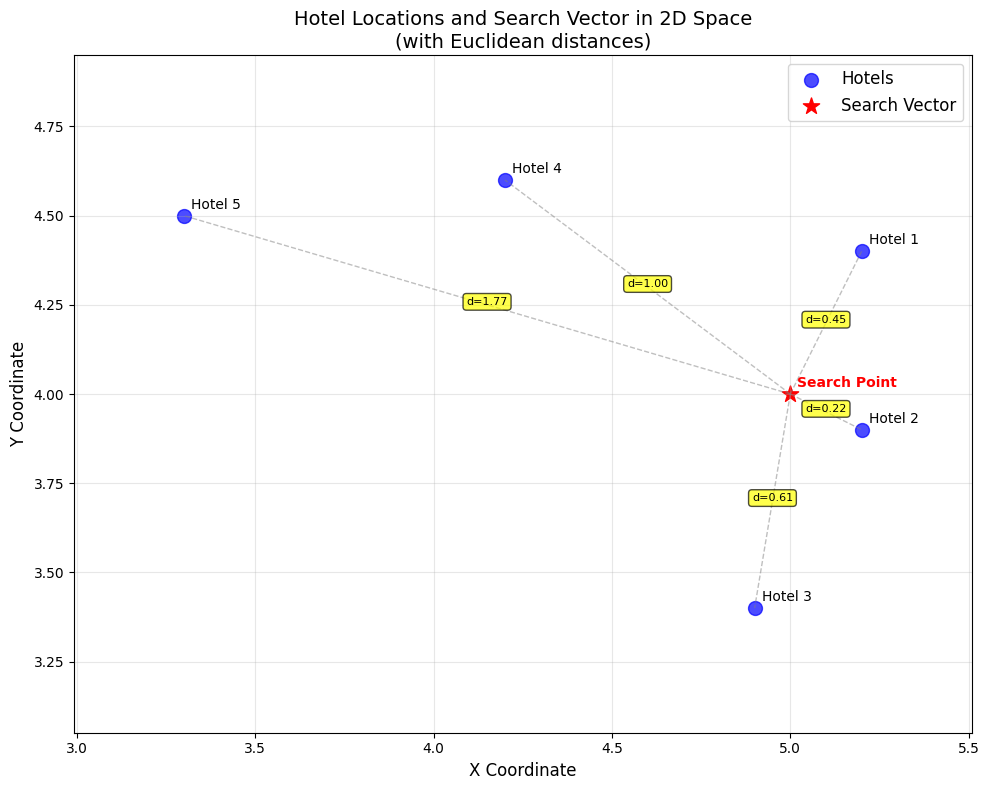


Search Results (ordered by similarity):
1. Hotel 2: Location [5.2, 3.9], Score: 0.9524, Distance: 0.22
2. Hotel 1: Location [5.2, 4.4], Score: 0.8333, Distance: 0.45
3. Hotel 3: Location [4.9, 3.4], Score: 0.7299, Distance: 0.61


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Extract hotel locations and search vector
hotel_locations = [
    [5.2, 4.4],  # Hotel 1
    [5.2, 3.9],  # Hotel 2  
    [4.9, 3.4],  # Hotel 3
    [4.2, 4.6],  # Hotel 4
    [3.3, 4.5]   # Hotel 5
]

search_vector = [5, 4]

# Convert to numpy arrays for easier plotting
hotels = np.array(hotel_locations)
search_point = np.array(search_vector)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot hotel locations
plt.scatter(hotels[:, 0], hotels[:, 1], 
           c='blue', s=100, alpha=0.7, 
           label='Hotels', marker='o')

# Plot search vector
plt.scatter(search_point[0], search_point[1], 
           c='red', s=150, 
           label='Search Vector', marker='*')

# Add hotel labels
for i, (x, y) in enumerate(hotel_locations):
    plt.annotate(f'Hotel {i+1}', (x, y), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, ha='left')

# Add search vector label
plt.annotate('Search Point', search_point, 
            xytext=(5, 5), textcoords='offset points',
            fontsize=10, ha='left', color='red', fontweight='bold')

# Draw lines from search point to each hotel to show distances
for i, hotel in enumerate(hotel_locations):
    plt.plot([search_point[0], hotel[0]], [search_point[1], hotel[1]], 
            'gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Calculate and display Euclidean distance
    distance = np.sqrt((search_point[0] - hotel[0])**2 + (search_point[1] - hotel[1])**2)
    mid_x = (search_point[0] + hotel[0]) / 2
    mid_y = (search_point[1] + hotel[1]) / 2
    plt.annotate(f'd={distance:.2f}', (mid_x, mid_y), 
                fontsize=8, ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))

# Customize the plot
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.title('Hotel Locations and Search Vector in 2D Space\n(with Euclidean distances)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Set equal aspect ratio and adjust limits
plt.axis('equal')
plt.xlim(2.5, 6)
plt.ylim(3, 5)

plt.tight_layout()
plt.show()

# Print the search results for reference
print("\nSearch Results (ordered by similarity):")
print("=" * 50)
for i, hit in enumerate(response['hits']['hits']):
    hotel_id = hit['_id']
    location = hit['_source']['location']
    score = hit['_score']
    distance = np.sqrt((search_point[0] - location[0])**2 + (search_point[1] - location[1])**2)
    print(f"{i+1}. Hotel {hotel_id}: Location {location}, Score: {score:.4f}, Distance: {distance:.2f}")

# Preparing vectors
In OpenSearch, you can either bring your own vectors or let OpenSearch generate them automatically from your data. Letting OpenSearch automatically generate your embeddings reduces data preprocessing effort at ingestion and search time.  

**Option 1**: Bring your own raw vectors or generated embeddings  
**Option 2**: Generate embeddings within OpenSearch

# KNN Vector Mapping with Different Engines and Space Types

This section demonstrates how different engine and space_type combinations affect KNN search results and performance. 

**Note**: `nmslib` engine is deprecated in OpenSearch 3.0.0+ and cannot be used for new index creation.

**Available Engines**: faiss, lucene

**Supported Space Types by Engine**:
- **faiss**: l2, cosinesimil (2 combinations)
- **lucene**: l1, l2, linf, cosinesimil, innerproduct (5 combinations)
- **Total combinations**: 7

**Note**: Not all engines support all space types. Check the engine documentation for compatibility.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import pandas as pd
import time

# Define the combinations we want to test
# Note: Different engines support different space types
# faiss: l2, cosinesimil
# lucene: l1, l2, linf, cosinesimil, innerproduct
engines_space_types = {
    'faiss': ['l2', 'cosinesimil'],
    'lucene': ['l1', 'l2', 'linf', 'cosinesimil', 'innerproduct']
}

# Note: hamming and hammingbit require bit_vector type, not knn_vector, so we exclude them for now
# Note: nmslib engine is deprecated in OpenSearch 3.0.0+ and cannot be used for new index creation

def create_knn_mapping(engine: str, space_type: str, dimension: int = 1024) -> Dict:
    """
    Create a KNN mapping configuration for a given engine and space type.
    
    Args:
        engine: 'faiss' or 'lucene' (nmslib is deprecated in OpenSearch 3.0.0+)
        space_type: Depends on engine:
                   - faiss: 'l2', 'cosinesimil'
                   - lucene: 'l1', 'l2', 'linf', 'cosinesimil', 'innerproduct'
        dimension: vector dimension (default 1024)
    
    Returns:
        Mapping configuration dictionary
    """
    mapping = {
        "settings": {
            "index": {
                "knn": True,
                "knn.algo_param.ef_search": 100
            }
        },
        "mappings": {
            "properties": {
                "my_vector": {
                    "type": "knn_vector",
                    "dimension": dimension,
                    "method": {
                        "name": "hnsw",
                        "space_type": space_type,
                        "engine": engine,
                        "parameters": {
                            "ef_construction": 128,
                            "m": 24
                        }
                    }
                },
                "title": {
                    "type": "text"
                }
            }
        }
    }
    return mapping

def create_test_index(client, index_name: str, engine: str, space_type: str, dimension: int = 1024) -> bool:
    """
    Create a test index with the specified engine and space type.
    
    Args:
        client: OpenSearch client
        index_name: Name of the index to create
        engine: Engine type ('faiss' or 'lucene')
        space_type: Space type (must be supported by the engine)
        dimension: Vector dimension
    
    Returns:
        True if successful, False otherwise
    """
    try:
        # Delete index if it exists
        if client.indices.exists(index=index_name):
            client.indices.delete(index=index_name)
        
        # Create mapping
        mapping = create_knn_mapping(engine, space_type, dimension)
        
        # Create index
        client.indices.create(index=index_name, body=mapping)
        print(f"✓ Created index '{index_name}' with engine='{engine}', space_type='{space_type}'")
        return True
    except Exception as e:
        print(f"✗ Failed to create index '{index_name}': {str(e)}")
        return False

def generate_test_vectors(num_vectors: int = 100, dimension: int = 1024, seed: int = 42) -> List[np.ndarray]:
    """
    Generate random test vectors.
    
    Args:
        num_vectors: Number of vectors to generate
        dimension: Dimension of each vector
        seed: Random seed for reproducibility
    
    Returns:
        List of numpy arrays representing vectors
    """
    np.random.seed(seed)
    vectors = []
    for _ in range(num_vectors):
        # Generate random vector and normalize it
        vector = np.random.randn(dimension)
        # Normalize to unit length for better results with normalized distance metrics
        vector = vector / np.linalg.norm(vector)
        vectors.append(vector)
    return vectors

def ingest_test_data(client, index_name: str, vectors: List[np.ndarray], num_vectors: int = None) -> Tuple[int, int]:
    """
    Ingest test vectors into an index.
    
    Args:
        client: OpenSearch client
        index_name: Name of the index
        vectors: List of vectors to ingest
        num_vectors: If specified, only ingest this many vectors
    
    Returns:
        Tuple of (success_count, failed_count)
    """
    if num_vectors is None:
        num_vectors = len(vectors)
    
    actions = []
    for i, vector in enumerate(vectors[:num_vectors]):
        action = {
            "_index": index_name,
            "_id": str(i + 1),
            "_source": {
                "my_vector": vector.tolist(),
                "title": f"Document {i + 1}"
            }
        }
        actions.append(action)
    
    # Bulk insert
    success, failed = bulk(client=client, actions=actions)
    print(f"  Ingested: {success} documents, Failed: {failed}")
    
    # Refresh index
    client.indices.refresh(index=index_name)
    
    return success, failed

print("Helper functions defined successfully!")
print("\nSupported Engine-SpaceType Combinations:")
total_combinations = 0
for engine, space_types in engines_space_types.items():
    num_combos = len(space_types)
    total_combinations += num_combos
    print(f"  {engine}: {space_types} ({num_combos} combinations)")
print(f"Total combinations to test: {total_combinations}")


Helper functions defined successfully!

Supported Engine-SpaceType Combinations:
  faiss: ['l2', 'cosinesimil'] (2 combinations)
  lucene: ['l1', 'l2', 'linf', 'cosinesimil', 'innerproduct'] (5 combinations)
Total combinations to test: 7


## Generate Test Data

In [5]:
# Generate test vectors
num_test_vectors = 50  # Number of documents to index
vector_dimension = 1024
test_vectors = generate_test_vectors(num_vectors=num_test_vectors, dimension=vector_dimension)
search_vector = test_vectors[0]  # Use first vector as search vector

print(f"Generated {num_test_vectors} test vectors with dimension {vector_dimension}")
print(f"Search vector shape: {search_vector.shape}")
print(f"Search vector norm: {np.linalg.norm(search_vector):.4f}")


Generated 50 test vectors with dimension 1024
Search vector shape: (1024,)
Search vector norm: 1.0000


## Test All Engine and Space Type Combinations

In [6]:
# Dictionary to store results from each combination
results = {}
k = 5  # Number of nearest neighbors to retrieve

for engine, space_types in engines_space_types.items():
    for space_type in space_types:
        print(f"\n{'='*70}")
        print(f"Testing: engine='{engine}', space_type='{space_type}'")
        print(f"{'='*70}")
        
        index_name = f"knn-test-{engine}-{space_type}".lower()
        
        try:
            # Create index
            if create_test_index(client, index_name, engine, space_type, vector_dimension):
                # Ingest data
                print(f"  Ingesting {num_test_vectors} test vectors...")
                success, failed = ingest_test_data(client, index_name, test_vectors, num_test_vectors)
                
                # Perform KNN search
                print(f"  Performing KNN search (k={k})...")
                search_query = {
                    "size": k,
                    "query": {
                        "knn": {
                            "my_vector": {
                                "vector": search_vector.tolist(),
                                "k": k
                            }
                        }
                    }
                }
                
                start_time = time.time()
                response = client.search(index=index_name, body=search_query)
                search_time = (time.time() - start_time) * 1000  # Convert to ms
                
                # Extract results
                hits = response['hits']['hits']
                result_data = {
                    'engine': engine,
                    'space_type': space_type,
                    'hits': hits,
                    'search_time_ms': search_time,
                    'success': True
                }
                
                # Calculate distances for each hit
                hit_distances = []
                for hit in hits:
                    hit_vector = np.array(hit['_source']['my_vector'])
                    
                    # Calculate different distance metrics
                    l2_distance = np.linalg.norm(search_vector - hit_vector)
                    l1_distance = np.sum(np.abs(search_vector - hit_vector))
                    linf_distance = np.max(np.abs(search_vector - hit_vector))
                    cosine_similarity = np.dot(search_vector, hit_vector) / (np.linalg.norm(search_vector) * np.linalg.norm(hit_vector))
                    inner_product = np.dot(search_vector, hit_vector)
                    
                    hit_distances.append({
                        'doc_id': hit['_id'],
                        'score': hit['_score'],
                        'l2': l2_distance,
                        'l1': l1_distance,
                        'linf': linf_distance,
                        'cosinesimil': cosine_similarity,
                        'innerproduct': inner_product
                    })
                
                result_data['hit_distances'] = hit_distances
                results[f"{engine}-{space_type}"] = result_data
                
                print(f"  Search completed in {search_time:.2f}ms")
                print(f"  Top {k} results:")
                for i, hit_data in enumerate(hit_distances):
                    print(f"    {i+1}. Doc {hit_data['doc_id']}: Score={hit_data['score']:.4f}")
                
        except Exception as e:
            print(f"  Error: {str(e)}")
            results[f"{engine}-{space_type}"] = {
                'engine': engine,
                'space_type': space_type,
                'success': False,
                'error': str(e)
            }

print(f"\n{'='*70}")
print(f"Testing completed!")
print(f"Successfully tested {sum(1 for r in results.values() if r.get('success', False))} combinations")
print(f"{'='*70}")



Testing: engine='faiss', space_type='l2'
✓ Created index 'knn-test-faiss-l2' with engine='faiss', space_type='l2'
  Ingesting 50 test vectors...
  Ingested: 50 documents, Failed: []
  Performing KNN search (k=5)...
  Search completed in 10.32ms
  Top 5 results:
    1. Doc 1: Score=1.0000
    2. Doc 45: Score=0.3544
    3. Doc 26: Score=0.3477
    4. Doc 16: Score=0.3463
    5. Doc 23: Score=0.3456

Testing: engine='faiss', space_type='cosinesimil'
✓ Created index 'knn-test-faiss-cosinesimil' with engine='faiss', space_type='cosinesimil'
  Ingesting 50 test vectors...
  Ingested: 50 documents, Failed: []
  Performing KNN search (k=5)...
  Search completed in 9.62ms
  Top 5 results:
    1. Doc 1: Score=1.0000
    2. Doc 45: Score=0.5445
    3. Doc 26: Score=0.5309
    4. Doc 16: Score=0.5280
    5. Doc 23: Score=0.5267

Testing: engine='lucene', space_type='l1'
✗ Failed to create index 'knn-test-lucene-l1': RequestError(400, 'mapper_parsing_exception', 'Failed to parse mapping [_doc]: V

## Visualization: Comparison of All Combinations

This visualization shows how different engine and space type combinations perform. For high-dimensional vectors (1024D), we project them to 2D using PCA for visualization purposes.

PCA explained variance ratio: [0.02930996 0.02880653]
Total variance explained: 0.0581


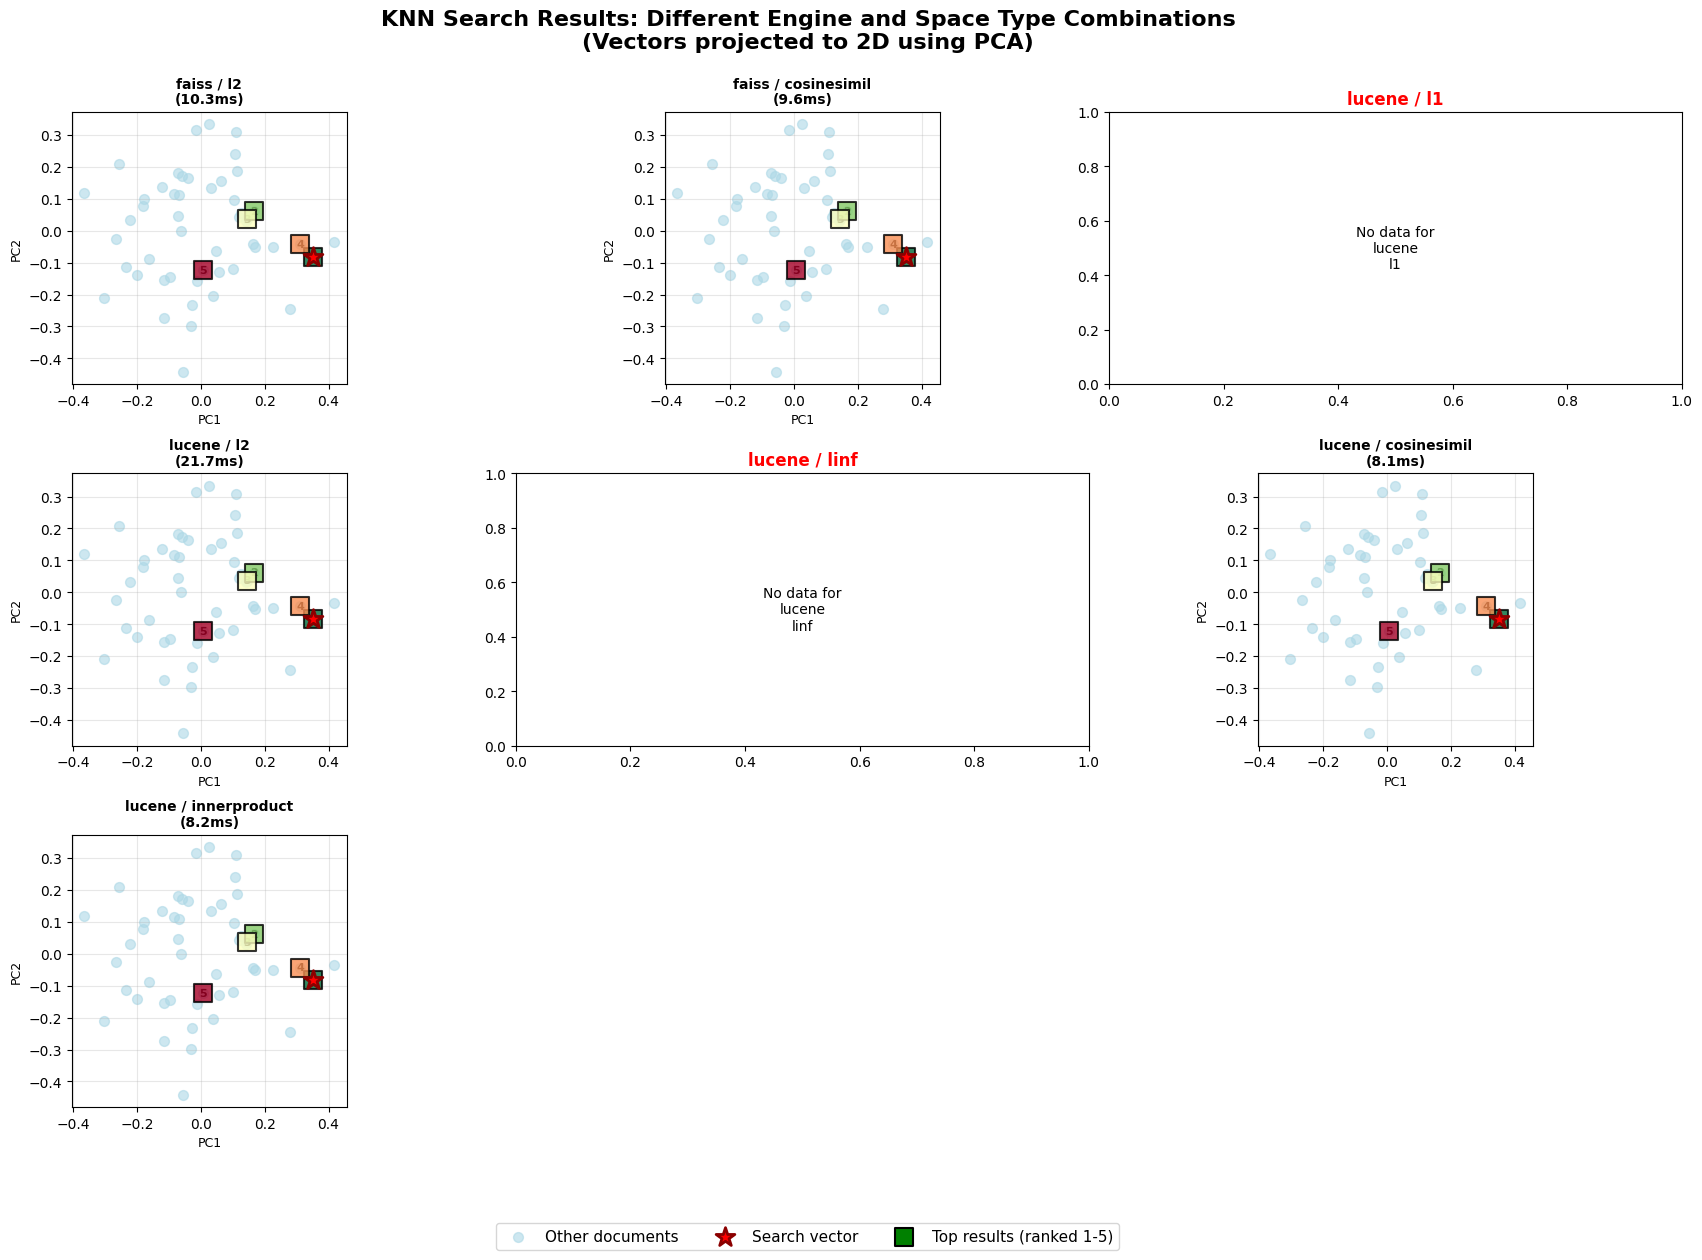

Visualization completed!


In [7]:
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle

# Project high-dimensional vectors to 2D using PCA for visualization
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(test_vectors)
search_vector_2d = pca.transform([search_vector])[0]

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# Generate all supported combinations
all_combinations = []
for engine, space_types in engines_space_types.items():
    for space_type in space_types:
        all_combinations.append((engine, space_type))

# Create subplots for each combination
num_combinations = len(all_combinations)
num_cols = 3
num_rows = (num_combinations + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
fig.suptitle('KNN Search Results: Different Engine and Space Type Combinations\n(Vectors projected to 2D using PCA)', 
             fontsize=16, fontweight='bold', y=0.995)

# Flatten axes if needed
if num_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, (engine, space_type) in enumerate(all_combinations):
    ax = axes[idx]
    key = f"{engine}-{space_type}"
    
    if key not in results:
        ax.text(0.5, 0.5, f"No data for\n{engine}\n{space_type}", 
               ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.set_title(f"{engine} / {space_type}", fontweight='bold', color='red')
        continue
    
    result = results[key]
    
    if not result.get('success', False):
        ax.text(0.5, 0.5, f"Failed:\n{result.get('error', 'Unknown error')}", 
               ha='center', va='center', transform=ax.transAxes, fontsize=9, color='red')
        ax.set_title(f"{engine} / {space_type}", fontweight='bold', color='red')
        continue
    
    # Plot all vectors
    ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], 
              c='lightblue', s=50, alpha=0.6, marker='o', label='Other docs')
    
    # Plot search vector
    ax.scatter(search_vector_2d[0], search_vector_2d[1], 
              c='red', s=200, marker='*', label='Search vector', zorder=5, edgecolors='darkred', linewidth=2)
    
    # Highlight the top k results
    hit_doc_ids = [hit['doc_id'] for hit in result['hit_distances']]
    hit_indices = [int(doc_id) - 1 for doc_id in hit_doc_ids]
    
    colors = plt.cm.RdYlGn(np.linspace(1, 0, len(hit_indices)))  # Red to Green gradient
    for i, hit_idx in enumerate(hit_indices):
        ax.scatter(vectors_2d[hit_idx, 0], vectors_2d[hit_idx, 1], 
                  c=[colors[i]], s=150, marker='s', alpha=0.8, 
                  edgecolors='black', linewidth=1.5, zorder=4)
        # Add rank number
        ax.annotate(str(i+1), (vectors_2d[hit_idx, 0], vectors_2d[hit_idx, 1]),
                   fontsize=8, fontweight='bold', ha='center', va='center')
    
    # Draw lines from search vector to top result
    if hit_indices:
        ax.plot([search_vector_2d[0], vectors_2d[hit_indices[0], 0]],
               [search_vector_2d[1], vectors_2d[hit_indices[0], 1]],
               'r--', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('PC1', fontsize=9)
    ax.set_ylabel('PC2', fontsize=9)
    title = f"{engine} / {space_type}"
    search_time = result.get('search_time_ms', 0)
    ax.set_title(f"{title}\n({search_time:.1f}ms)", fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

# Remove extra subplots
for idx in range(num_combinations, len(axes)):
    fig.delaxes(axes[idx])

# Add legend
handles = [
    plt.scatter([], [], c='lightblue', s=50, alpha=0.6, marker='o'),
    plt.scatter([], [], c='red', s=200, marker='*', edgecolors='darkred', linewidth=2),
    plt.scatter([], [], c='green', s=150, marker='s', edgecolors='black', linewidth=1.5),
]
labels = ['Other documents', 'Search vector', 'Top results (ranked 1-5)']
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=3, fontsize=11)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()

print("Visualization completed!")


## Performance and Results Comparison

In [8]:
# Create a comparison table
comparison_data = []

for key, result in results.items():
    if result.get('success', False):
        engine = result['engine']
        space_type = result['space_type']
        search_time = result.get('search_time_ms', 0)
        
        # Get top result score and distance
        top_score = result['hit_distances'][0]['score'] if result['hit_distances'] else None
        top_l2_dist = result['hit_distances'][0]['l2'] if result['hit_distances'] else None
        
        comparison_data.append({
            'Engine': engine,
            'Space Type': space_type,
            'Search Time (ms)': f"{search_time:.2f}",
            'Top Score': f"{top_score:.4f}" if top_score else "N/A",
            'Top L2 Distance': f"{top_l2_dist:.4f}" if top_l2_dist else "N/A"
        })
    else:
        comparison_data.append({
            'Engine': result['engine'],
            'Space Type': result['space_type'],
            'Search Time (ms)': 'FAILED',
            'Top Score': 'FAILED',
            'Top L2 Distance': 'FAILED'
        })

df_comparison = pd.DataFrame(comparison_data)
print("\nComparison Table: Engine and Space Type Combinations")
print("="*90)
print(df_comparison.to_string(index=False))
print("="*90)



Comparison Table: Engine and Space Type Combinations
Engine   Space Type Search Time (ms) Top Score Top L2 Distance
 faiss           l2            10.32    1.0000          0.0000
 faiss  cosinesimil             9.62    1.0000          0.0000
lucene           l2            21.69    1.0000          0.0000
lucene  cosinesimil             8.10    1.0000          0.0000
lucene innerproduct             8.19    2.0000          0.0000


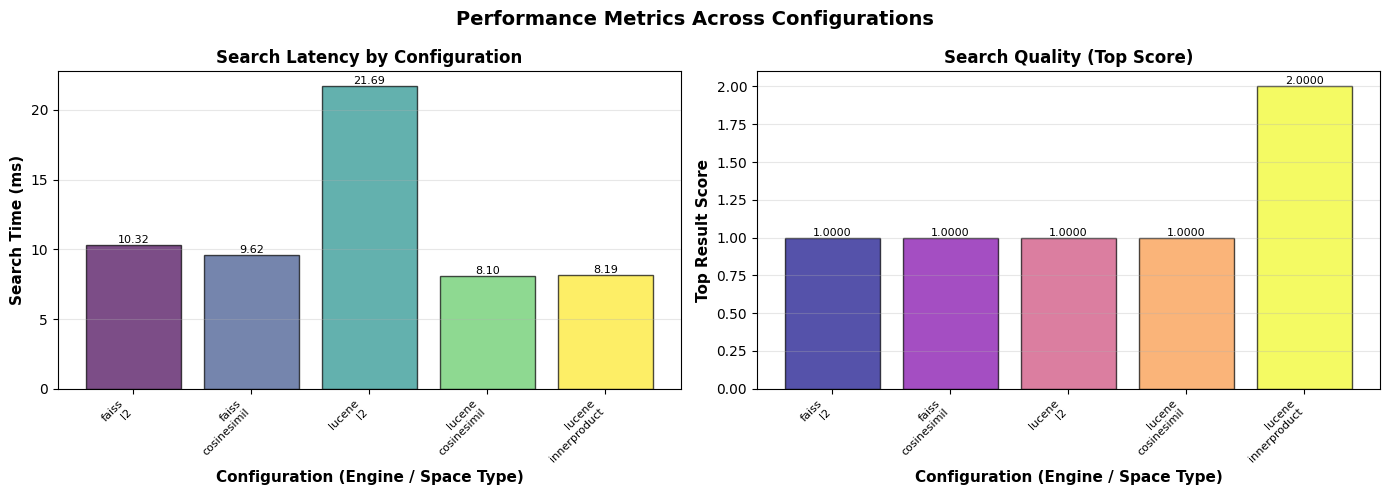


Performance metrics plotted successfully!


In [9]:
# Performance analysis visualization
successful_results = {k: v for k, v in results.items() if v.get('success', False)}

if successful_results:
    # Extract data for plotting
    configs = list(successful_results.keys())
    search_times = [successful_results[config].get('search_time_ms', 0) for config in configs]
    top_scores = [successful_results[config]['hit_distances'][0]['score'] 
                  for config in configs if successful_results[config]['hit_distances']]
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Performance Metrics Across Configurations', fontsize=14, fontweight='bold')
    
    # Plot 1: Search Time
    ax1 = axes[0]
    colors_time = plt.cm.viridis(np.linspace(0, 1, len(configs)))
    bars1 = ax1.bar(range(len(configs)), search_times, color=colors_time, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Configuration (Engine / Space Type)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Search Time (ms)', fontsize=11, fontweight='bold')
    ax1.set_title('Search Latency by Configuration', fontsize=12, fontweight='bold')
    ax1.set_xticks(range(len(configs)))
    ax1.set_xticklabels([c.replace('-', '\n') for c in configs], rotation=45, ha='right', fontsize=8)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    # Plot 2: Top Result Score
    ax2 = axes[1]
    colors_score = plt.cm.plasma(np.linspace(0, 1, len(configs)))
    bars2 = ax2.bar(range(len(configs)), top_scores, color=colors_score, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Configuration (Engine / Space Type)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Top Result Score', fontsize=11, fontweight='bold')
    ax2.set_title('Search Quality (Top Score)', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(len(configs)))
    ax2.set_xticklabels([c.replace('-', '\n') for c in configs], rotation=45, ha='right', fontsize=8)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("\nPerformance metrics plotted successfully!")


## Detailed Results and Insights

In [10]:
# Print detailed analysis for each successful configuration
print("\n" + "="*100)
print("DETAILED RESULTS FOR EACH CONFIGURATION")
print("="*100)

for key, result in sorted(results.items()):
    if result.get('success', False):
        engine = result['engine']
        space_type = result['space_type']
        search_time = result.get('search_time_ms', 0)
        
        print(f"\n📊 Configuration: {engine.upper()} engine with {space_type.upper()} space type")
        print(f"   Search Time: {search_time:.2f}ms")
        print(f"\n   Top {len(result['hit_distances'])} Results:")
        print(f"   {'Rank':<6} {'Doc ID':<8} {'Score':<10} {'L1':<10} {'L2':<10} {'Linf':<10} {'Cosine':<10} {'Inner':<10}")
        print(f"   {'-'*72}")
        
        for i, hit in enumerate(result['hit_distances'], 1):
            print(f"   {i:<6} {hit['doc_id']:<8} {hit['score']:<10.4f} {hit['l1']:<10.4f} "
                  f"{hit['l2']:<10.4f} {hit['linf']:<10.4f} {hit['cosinesimil']:<10.4f} {hit['innerproduct']:<10.4f}")
    else:
        error = result.get('error', 'Unknown error')
        print(f"\n❌ Configuration: {result['engine'].upper()} engine with {result['space_type'].upper()} space type")
        print(f"   Status: FAILED")
        print(f"   Error: {error}")

print("\n" + "="*100)



DETAILED RESULTS FOR EACH CONFIGURATION

📊 Configuration: FAISS engine with COSINESIMIL space type
   Search Time: 9.62ms

   Top 5 Results:
   Rank   Doc ID   Score      L1         L2         Linf       Cosine     Inner     
   ------------------------------------------------------------------------
   1      1        1.0000     0.0000     0.0000     0.0000     1.0000     1.0000    
   2      45       0.5445     34.0885    1.3498     0.1534     0.0890     0.0890    
   3      26       0.5309     34.5856    1.3698     0.1434     0.0618     0.0618    
   4      16       0.5280     35.3826    1.3741     0.1608     0.0560     0.0560    
   5      23       0.5267     35.1850    1.3760     0.1526     0.0534     0.0534    

📊 Configuration: FAISS engine with L2 space type
   Search Time: 10.32ms

   Top 5 Results:
   Rank   Doc ID   Score      L1         L2         Linf       Cosine     Inner     
   ------------------------------------------------------------------------
   1      1       

## Summary and Recommendations

### Engine Characteristics

**faiss** (Facebook AI Similarity Search)
- Highly optimized for large-scale similarity search
- Excellent performance on GPU (if available)
- Supports: l2, cosinesimil
- **Use when**: You have large datasets and need maximum performance with standard distance metrics

**lucene**
- Native Java implementation
- Good integration with OpenSearch
- Supports all available space types: l1, l2, linf, cosinesimil, innerproduct
- Available since OpenSearch 2.0
- **Use when**: You want tight integration with OpenSearch internals or need specialized distance metrics

### Space Type Characteristics

| Space Type | Use Case | Formula | Supported Engines |
|---|---|---|---|
| **l2** | Euclidean distance | √(Σ(xi - yi)²) | faiss, lucene |
| **l1** | Manhattan distance | Σ\|xi - yi\| | lucene only |
| **linf** | Chebyshev distance | max(\|xi - yi\|) | lucene only |
| **cosinesimil** | Angle-based similarity | 1 - (u·v)/(‖u‖·‖v‖) | faiss, lucene |
| **innerproduct** | Dot product similarity | u·v | lucene only |

### Engine-SpaceType Support Matrix

```
        | l2     | l1     | linf   | cosinesimil | innerproduct |
--------|--------|--------|--------|-------------|--------------|
faiss   | ✓      | ✗      | ✗      | ✓           | ✗            |
lucene  | ✓      | ✓      | ✓      | ✓           | ✓            |
```

### Recommendations

1. **For general similarity search with normalized vectors**: Use **l2 + faiss**
   - Best performance, widely used for embedding similarity

2. **For semantic search (embeddings)**: Use **cosinesimil + faiss** or **cosinesimil + lucene**
   - Most natural for normalized embeddings from language models

3. **For maximum performance at scale**: Use **faiss** with any compatible space type
   - GPU-optimized, best for large datasets

4. **For normalized vectors**: Use **innerproduct + lucene** or **cosinesimil**
   - Mathematically equivalent for unit-norm vectors

5. **For Manhattan distance metric**: Use **l1 + lucene**
   - Only available in lucene engine

6. **For Chebyshev distance**: Use **linf + lucene**
   - Only available in lucene engine, useful for specific distance metrics

7. **For OpenSearch 3.0.0+**: Use **faiss** or **lucene** (nmslib is deprecated)
   - nmslib no longer supported in new index creation

### Performance Tips

- **Normalization**: Normalize vectors before indexing for better results with normalized distance metrics (cosinesimil, innerproduct)
- **ef_construction**: Use appropriate value (higher = better accuracy but slower indexing, typical: 128-256)
- **m parameter**: Adjust based on memory constraints (higher = more connections = more memory, typical: 16-32)
- **ef_search**: Set based on your latency requirements (affects search accuracy vs. speed)
- **Engine selection**: Test both faiss and lucene if you need basic space types; choose faiss for maximum performance
- **Monitoring**: Monitor search performance and index size to find the right balance

### Migration from OpenSearch 2.x to 3.x

If upgrading from OpenSearch 2.x:
- **nmslib** is no longer supported in OpenSearch 3.0.0+
- Reindex data to use **faiss** or **lucene** engine instead
- Existing indices with nmslib will need to be migrated
- Consider performance: faiss is generally faster than lucene for basic metrics
